In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
from functions import shift_atoms, transform_list_hkl_p63, get_structure_factor

num_threads = 2  

# Configure TensorFlow to use multiple threads
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)

print(f"Using {num_threads} threads for intra-op and inter-op parallelism.")

Using 2 threads for intra-op and inter-op parallelism.


Define the function containing the fitting parameters

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- `fun_tf()` correspond to the **structure factor calculation function** (one has to convert it to a **TF-compatible** function)
- <span style="color:red">If conversion to TF-compatible function is not possible, then this approach will probably not work (or becomes much more tedious at least)</span>

In [2]:
def fun_tf(x, pars):
    """
    Function depending on parameters to be fitted.

    Parameters
    ----------
    x : Tensor
        3D Tensor of shape [N, 3] representing the hkl vectors
    pars : List or Tensor
        1D Tensor with six elements representing the parameters
    """
    # Modify structure with parameters
    modified_struct  = shift_atoms(*pars)
    
    # Compute the structure factor for hkl
    struct_self_hkl = tf.map_fn(
        lambda hkl: get_structure_factor(hkl, modified_struct), 
        x, 
        fn_output_signature=tf.complex64  
    )
    
    # Compute the structure factor for [h, -k, l]
    struct_self_neg_k = tf.map_fn(
        lambda hkl: get_structure_factor([hkl[0], -hkl[1], hkl[2]], modified_struct),  # Negate only the k-value
        x, 
        fn_output_signature=tf.complex64  
    )
    
    # Combine the intensities for hkl and -hkl by adding them together
    intensity = tf.abs(struct_self_hkl) ** 2 + tf.abs(struct_self_neg_k) ** 2
    
    # Normalize the intensity to the maximum value
    return intensity / tf.reduce_max(intensity)

In [3]:
# Example input data
x_example = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]], dtype=np.float32)
pars_example = np.array([-0.01, 0.01, 0, 0.04, -0.2, 0.01], dtype=np.float32)

# Convert to TensorFlow tensors
x_example_tf = tf.convert_to_tensor(x_example)
pars_example_tf = tf.convert_to_tensor(pars_example)

print(tf.complex(0.0, -1.0))
print(tf.complex(2 * np.pi, 0.0))
print(tf.complex(0.0, -1.0)*tf.complex(2 * np.pi, 0.0))
# Call the function with the example data
result = fun_tf(x_example_tf, pars_example_tf)
# Print the result
tf.print("Result shape:", tf.shape(result))
tf.print("Result:", result)

tf.Tensor(-1j, shape=(), dtype=complex64)
tf.Tensor((6.2831855+0j), shape=(), dtype=complex64)
tf.Tensor(-6.2831855j, shape=(), dtype=complex64)
Result shape: [3]
Result: [1 0.81468457 0.818806112]


Sample the model parameters (fitting parameters)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths

In [4]:
experimental_data = pd.read_csv('/home/mariolb/repos/CrystalClearFit/DistortionFit/new_data.csv')

hkl_list = experimental_data[["h", "k", "l"]].values.tolist()
hkl_list_trans = transform_list_hkl_p63(hkl_list)

max_par_value = 0.01
print(experimental_data.shape)
print(hkl_list_trans[0:5])

(866, 16)
tf.Tensor(
[[ 0. -0. -1.]
 [ 0.  2.  0.]
 [ 0. -2. -2.]
 [ 0.  4.  1.]
 [ 0. -4. -3.]], shape=(5, 3), dtype=float32)


Sample the "training data" (features and labels)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The features are the (h,k,l) coordinates (e.g. a vector of size `n_features` x 3, i.e. `n_dim = 3`)
- Maybe one has to normalize the features (i.e. not using integers but floats between -1 (0) and 1)? Before passing them to the structure calculation function, they should be again rescaled to integers
- The labels would be the experimental intensities (again, maybe have to be normalized to the range between 0 and 1)

In [5]:
n_features = experimental_data.shape[0]
n_dim = 3

features = hkl_list_trans
labels = experimental_data["intensity_exp"].tolist()
labels = tf.convert_to_tensor(labels, dtype=tf.float32)
print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print(labels[0:5])


Features shape: (866, 3)
Labels shape: (866,)
tf.Tensor([0.         0.         0.02016284 0.02016284 0.10172065], shape=(5,), dtype=float32)


Define a simple model

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The six parameters (a,b,c,d,e,f) correspond to the fractional atomic shifts in the modes w.r.t. unit cell lengths
- Instead of `sigmoid`, `tanh` should be applied to the parameters before passing them to the structure factor calculation function (ensures smoother gradient landscape)
- The `tanh` function can furthermore be limited to a specific range (e.g. if atomic distortions should not exceed +- 0.1)

In [6]:
class FunAsLayer(tf.keras.layers.Layer):
    def __init__(self, max_par_value=0.01, **kwargs):
        super().__init__(**kwargs)
        self.max_par_value = max_par_value

    def build(self, input_shape):
        # Define six trainable parameters
        self.a = self.add_weight(name='a', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.b = self.add_weight(name='b', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.c = self.add_weight(name='c', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.d = self.add_weight(name='d', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.e = self.add_weight(name='e', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        self.f = self.add_weight(name='f', shape=(), initializer=tf.keras.initializers.he_uniform(), trainable=True)
        super().build(input_shape)

    def call(self, inputs):
        # Apply tanh to ensure parameters stay within the [-0.1, 0.1] range
        a = self.max_par_value * tf.tanh(self.a)
        b = self.max_par_value * tf.tanh(self.b)
        c = self.max_par_value * tf.tanh(self.c)
        d = self.max_par_value * tf.tanh(self.d)
        e = self.max_par_value * tf.tanh(self.e)
        f = self.max_par_value * tf.tanh(self.f)
        
        # Call your fun_tf function to get the output
        return fun_tf(inputs, [a, b, c, d, e, f])

    def compute_output_shape(self, input_shape):
        # If the input has shape (None, 3), return the same shape
        return (input_shape[0], 1)  # This assumes your output is of shape (None, 1)


Create optimizer and define loss function

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The learning rate must be determined by experimentation (same holds for the batch size and the number of epochs below)
- As a loss function, one can try either MSE or R-score (MSE seems to be the more "natural choice" in this case)

In [10]:
# Define the custom loss function
class RFactorLoss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(tf.abs(y_true))

# Define the custom metric function
def r_factor_metric(y_true, y_pred):
    return tf.reduce_sum(tf.abs(y_true - y_pred)) / tf.reduce_sum(tf.abs(y_true))

# Instantiate the Adam optimizer
optim = tf.keras.optimizers.Adam(learning_rate=2e-2)


Train the model for n iterations (to try different initial weights)

<span style="color:yellow">Note on actual unit cell structure refinement problem:</span>
- The number of iterations defines the "starting position" $w_0$ of the gradient descent algorithm
- Because there are probably many local minima, changing $w_0$ allows the algorithm to find different minima and increases the chances of finding the global minima

In [11]:
histories = []
n_iter = 4

min_loss = np.inf
best_pars = None

# List to store the loss values for each epoch
all_losses = []

for i in range(n_iter):
    # Create the model
    inputs = tf.keras.Input(shape=(n_dim,))
    outputs = FunAsLayer(max_par_value)(inputs)
    model = tf.keras.Model(inputs, outputs)

    # Compile the model with the custom loss function and metric
    model.compile(
        optimizer=optim,
        loss=RFactorLoss(),
        metrics=[r_factor_metric]
    )
    
    # Use tqdm to create a custom progress bar for each epoch
    with tqdm(total=1000, desc=f"Iteration {i+1}") as pbar:
        # List to store loss for this iteration
        iteration_losses = []

        for epoch in range(1000):
            # Train the model for one step (epoch)
            history = model.fit(
                x=features,  
                y=labels,    
                batch_size=866,
                epochs=1,  # Train for one epoch at a time
                verbose=0  # No output during training
            )
            
            # Update progress bar
            pbar.update(1)
            
            # Store the loss for this epoch
            epoch_loss = history.history['loss'][-1]
            iteration_losses.append(epoch_loss)
            
            # Update progress bar description with current loss
            pbar.set_postfix(loss=epoch_loss)

        # Append the losses for this iteration to the overall list
        all_losses.append(iteration_losses)
        histories.append(history)

    # Check final loss
    final_loss = iteration_losses[-1]

    if final_loss < min_loss:
        # Update best model parameters
        best_model_pars = [max_par_value * tf.tanh(model.layers[-1].get_weights()[i]) for i in range(6)]
        min_loss = final_loss
        rf = r_factor_metric(labels, fun_tf(features, best_model_pars))
        print(f"Iteration {i+1} - New best loss: {min_loss:.2e} (R-factor: {rf:.2e})")


Iteration 1: 100%|██████████| 1000/1000 [10:39<00:00,  1.56it/s, loss=1.03]


Iteration 1 - New best loss: 1.03e+00 (R-factor: 1.03e+00)


Iteration 4: 100%|██████████| 1000/1000 [10:27<00:00,  1.59it/s, loss=1.03]


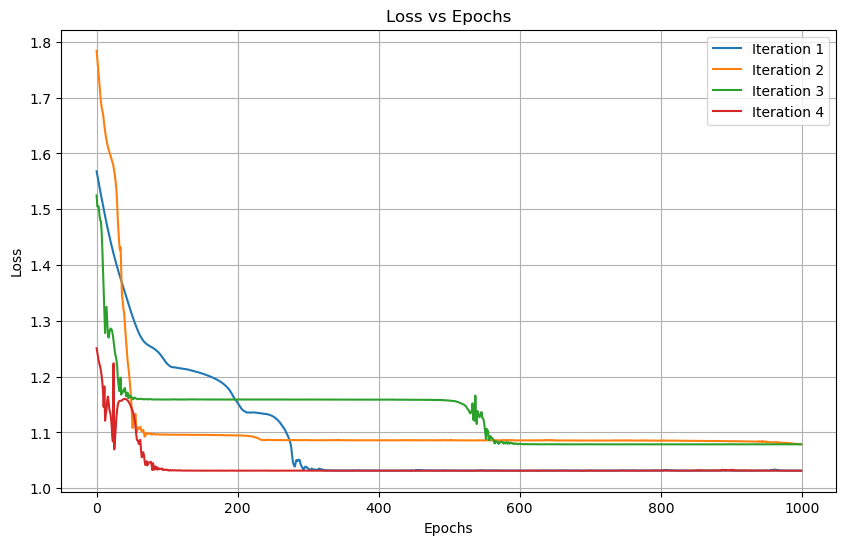

Best model parameters:
Parameter 1: 0.0000
Parameter 2: -0.0006
Parameter 3: 0.0100
Parameter 4: 0.0054
Parameter 5: 0.0008
Parameter 6: 0.0007
Optimizer: 0.02
Loss function: <__main__.RFactorLoss object at 0x000002062DC14670>
Metric function: <function r_factor_metric at 0x00000206862F5900>
Maximum parameter value: 0.01
Number of iterations: 4
Number of features: 866
Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 3)]               0         
                                                                 
 fun_as_layer_7 (FunAsLayer)  (None,)                  6         
                                                                 
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Plotting the loss values
plt.figure(figsize=(10, 6))

# Plot the loss values for each iteration
for i, loss_values in enumerate(all_losses):
    plt.plot(loss_values, label=f'Iteration {i+1}')

plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Print the best model parameters
print("Best model parameters:")
for i, par in enumerate(best_model_pars):
    print(f"Parameter {i+1}: {par.numpy():.4f}")
    
# Print the model summary
print("Optimizer:", optim.learning_rate.numpy())
print("Loss function:", RFactorLoss())
print("Metric function:", r_factor_metric)
print("Maximum parameter value:", max_par_value)
print("Number of iterations:", n_iter)
print("Number of features:", n_features)
model.summary()